In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import jax
import jax.numpy as jnp
import jax.scipy.special as jss
import intensity_models
from intensity_models import pop_model, pop_cosmo_model
import lal
import lalsimulation as ls
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import paths
import pandas as pd
import re
import scipy.stats as ss
import seaborn as sns
import time
from utils import jnp_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

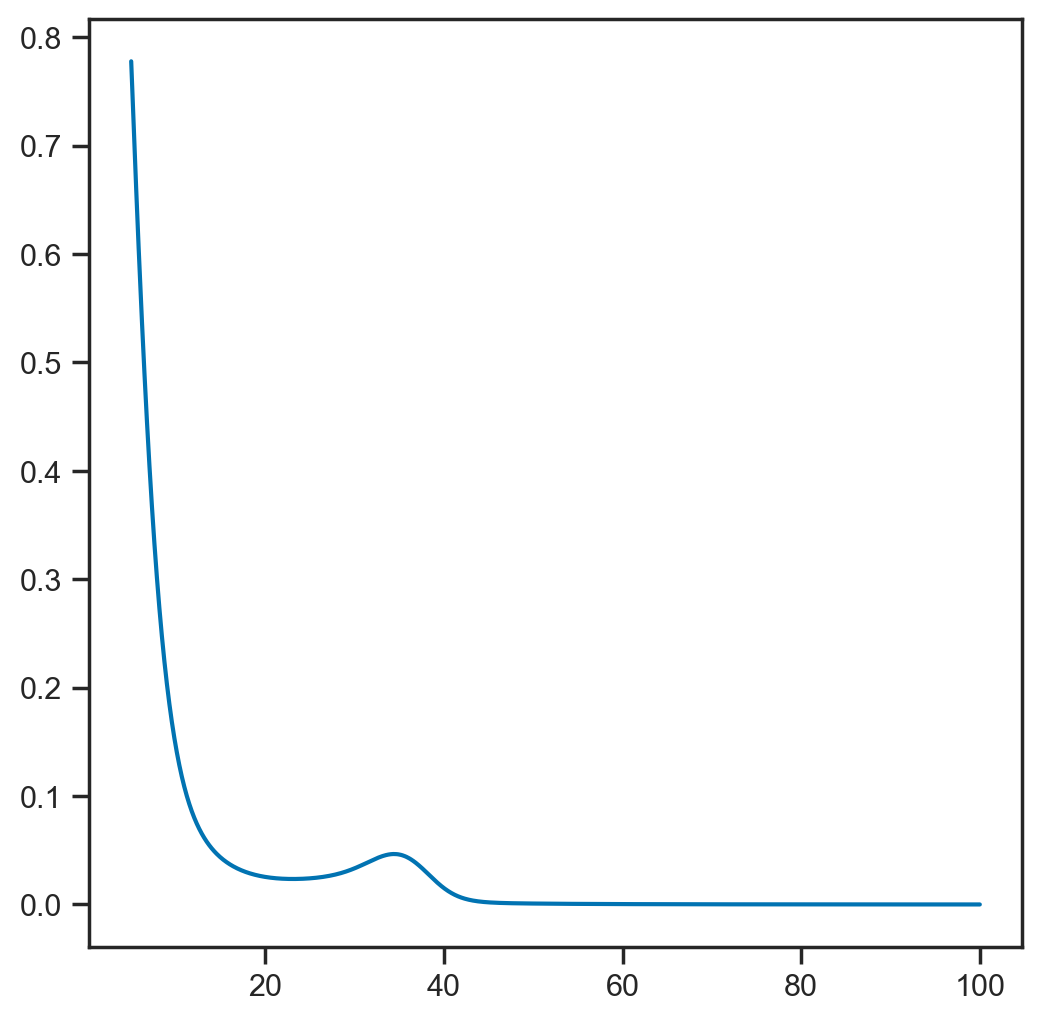

In [3]:
m = np.linspace(5, 100, 1024)
plt.plot(m, np.exp(weighting.default_log_dNdmdqdV(m, np.ones_like(m), np.zeros_like(m))))

In [5]:
np.random.randint(1<<32)

3281922803

In [8]:
trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: t

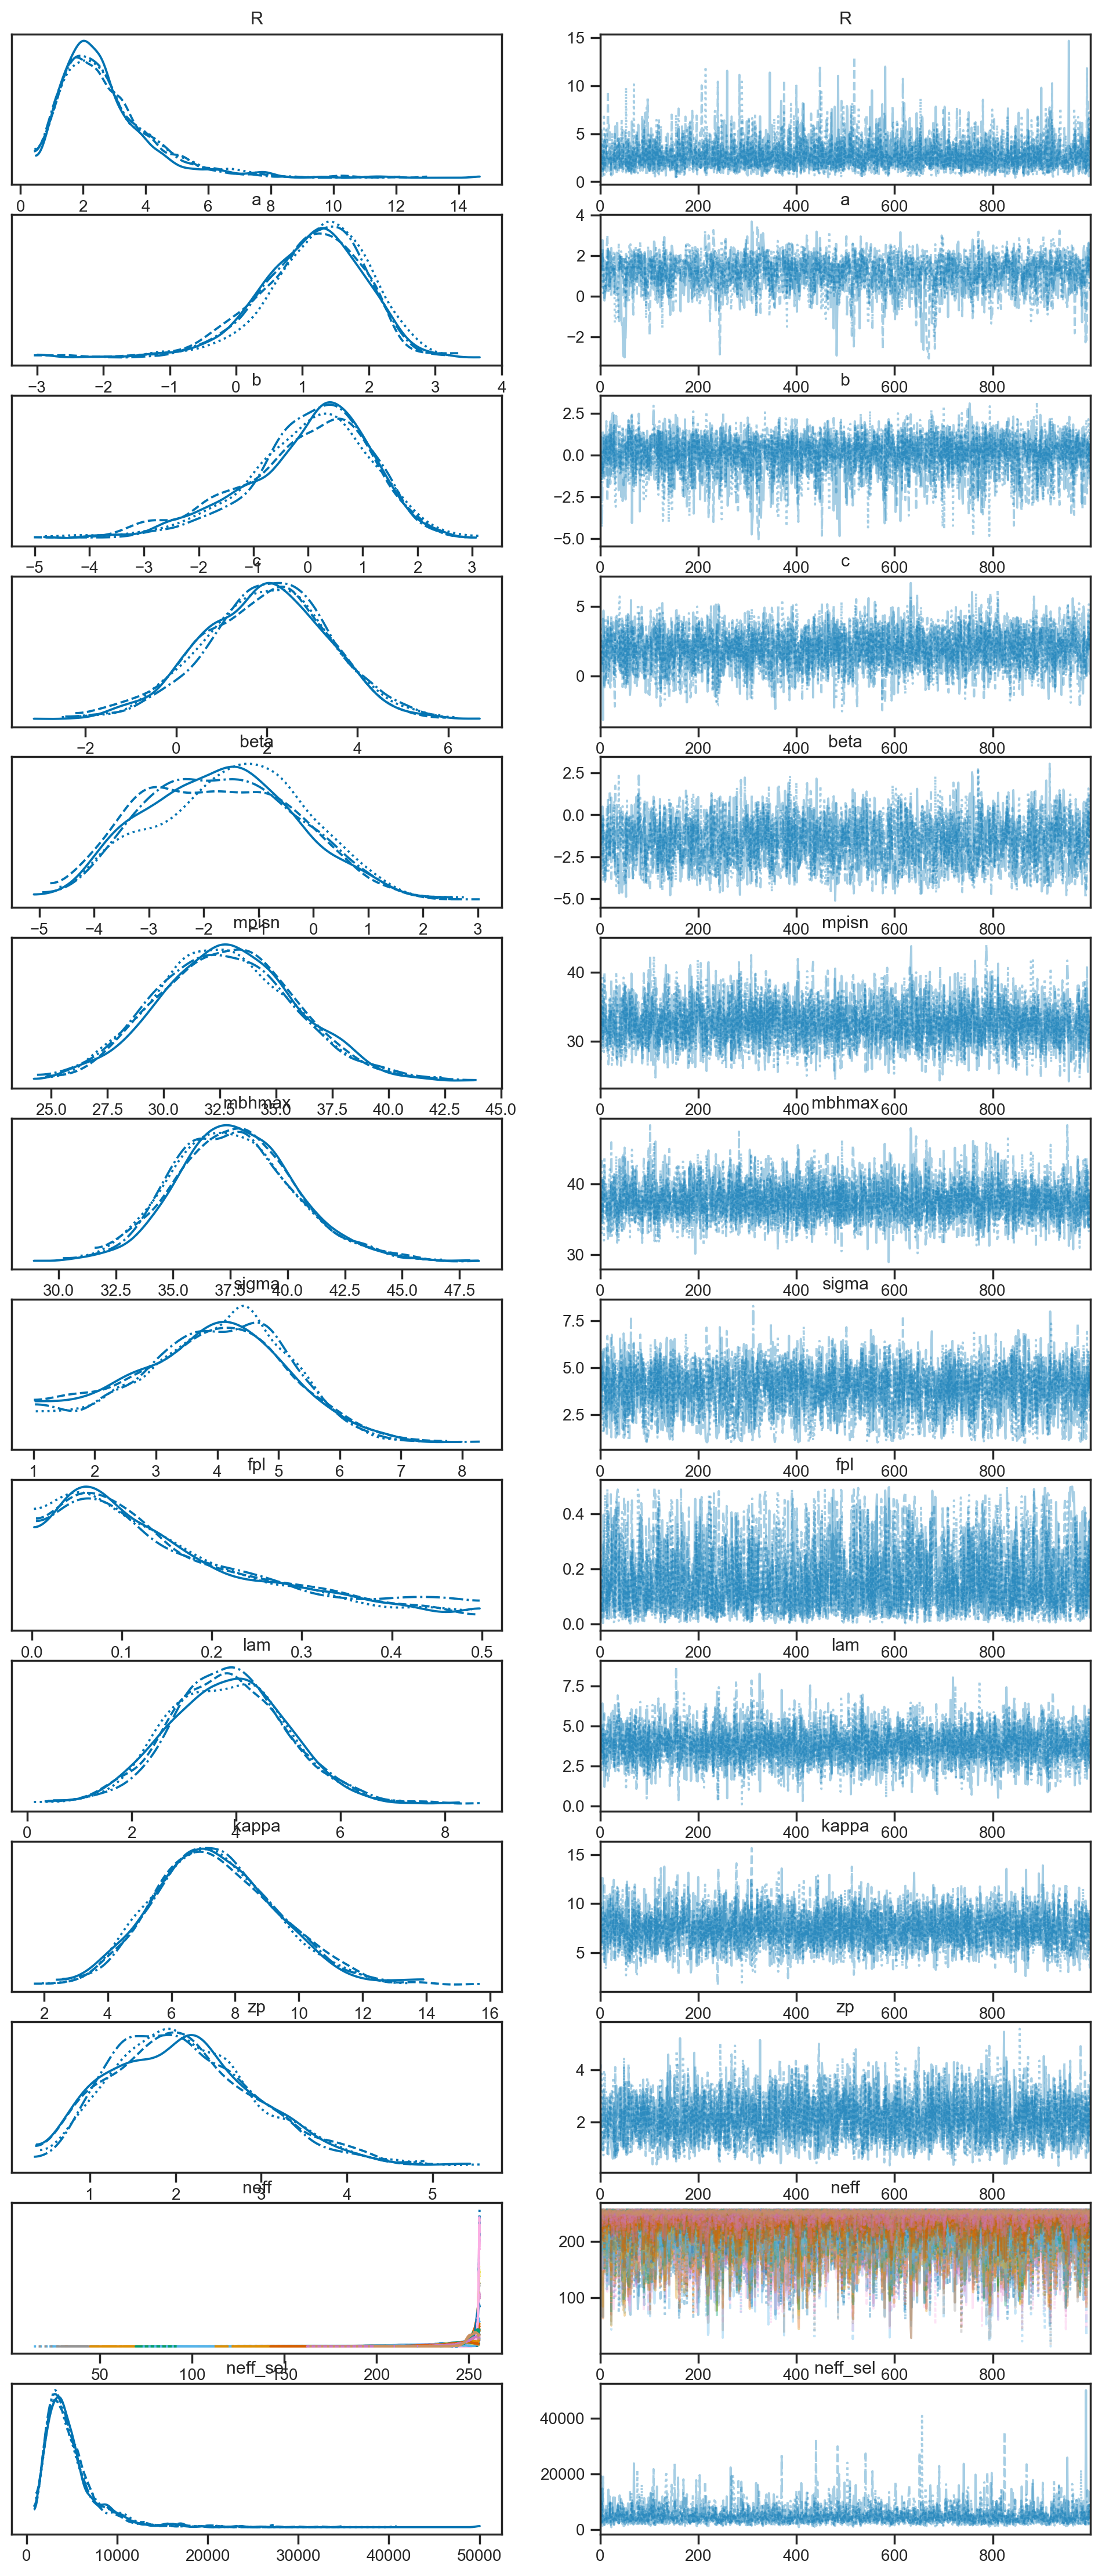

In [10]:
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'lam', 'kappa', 'zp', 'neff', 'neff_sel'])

In [4]:
inj = pd.read_hdf('../data/mock_injections.h5', key='true_parameters')

In [5]:
obs = pd.read_hdf('../data/mock_observations.h5', 'observations')
obs['m1_det'] = obs['m1']*(1 + obs['z'])
obs['dl'] = Planck18.luminosity_distance(obs['z'].to_numpy()).to(u.Gpc).value

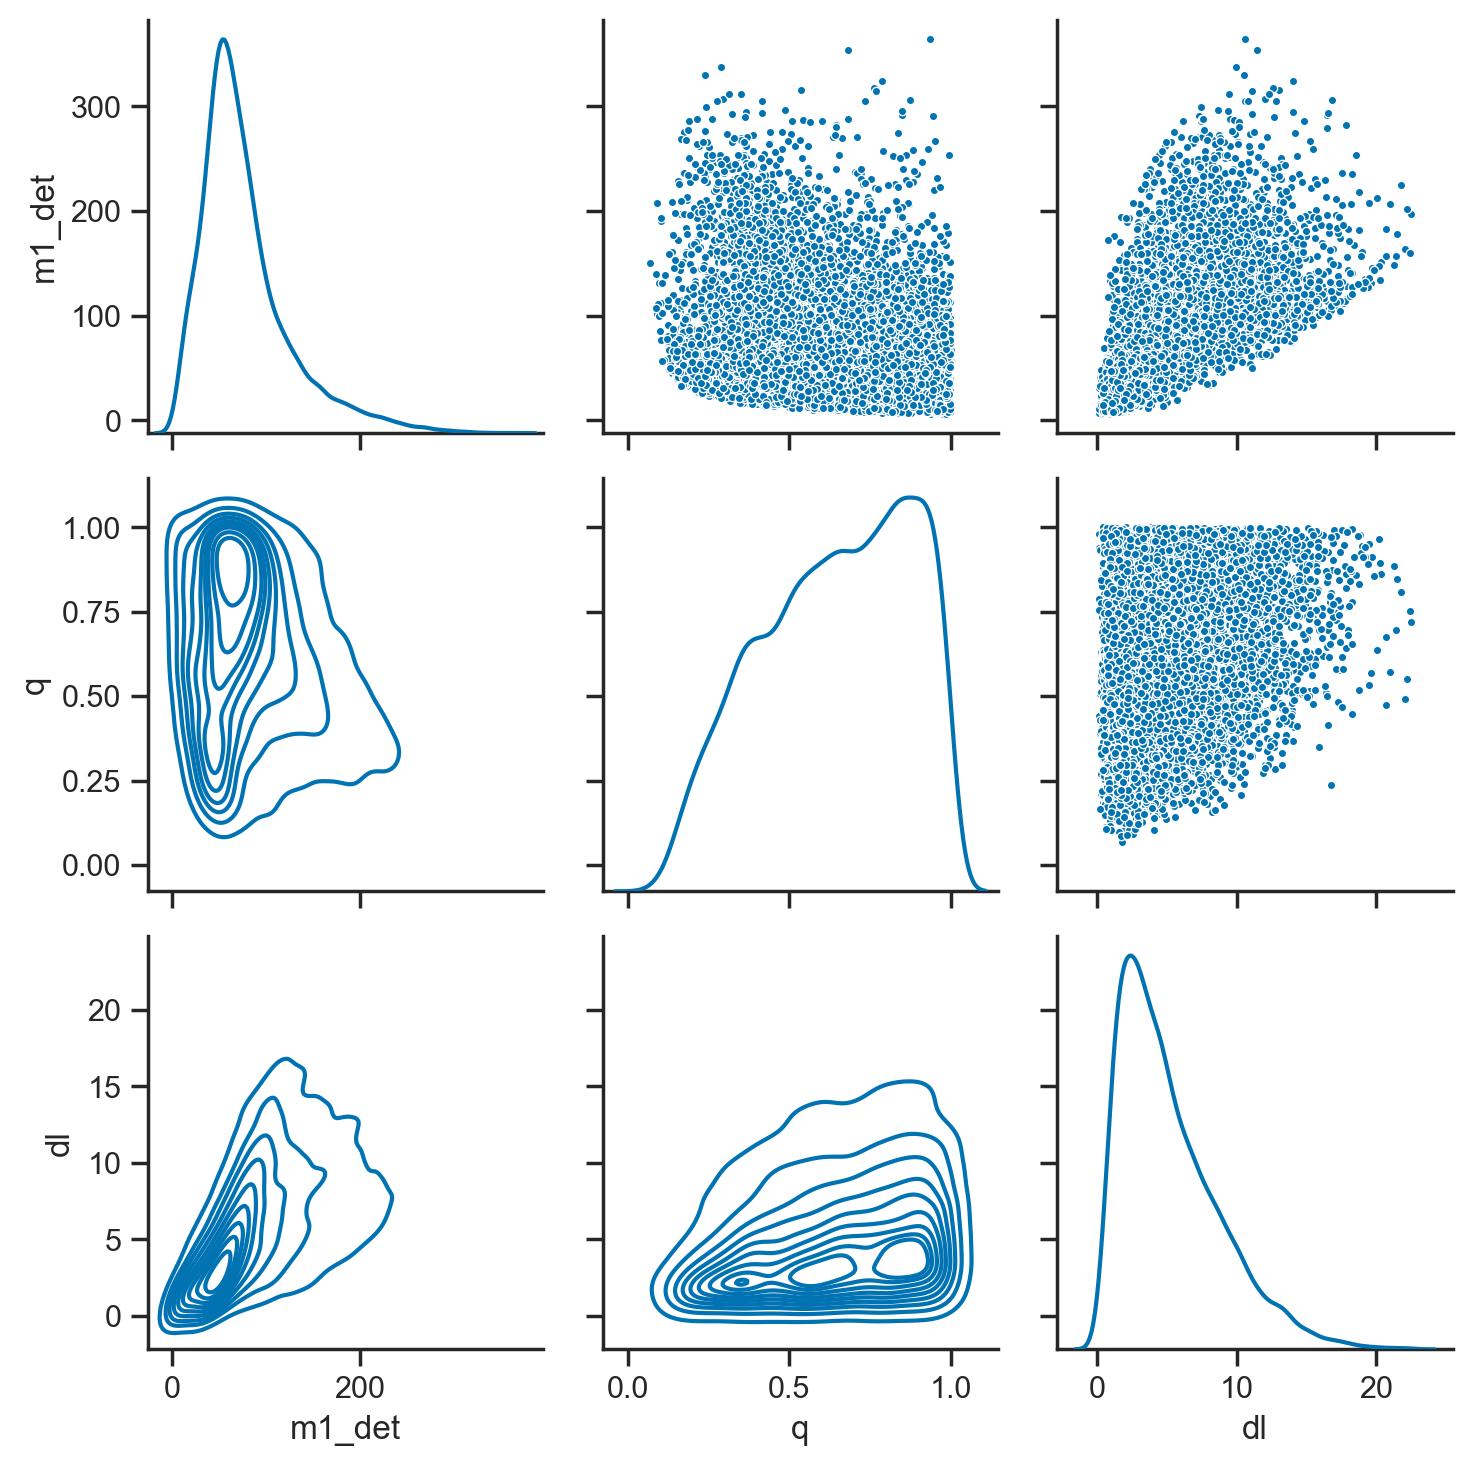

In [6]:
pg = sns.PairGrid(obs[['m1_det', 'q', 'dl']], diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')

In [7]:
i = np.random.randint(len(obs))
row = obs.iloc[i]
m1d, q, dl, wt = weighting.draw_mock_samples(row['log_mc_obs'], row['sigma_log_mc'], row['q_obs'], row['sigma_q'], row['log_dl_obs'], row['sigma_log_dl'], size=1000)

In [9]:
nex = np.random.poisson(weighting.default_parameters.R*np.sum(weighting.default_pop_wt(obs['m1'], obs['q'], obs['z'])/obs['pdraw_mqz'])/len(inj))

In [10]:
n = np.random.poisson(weighting.default_parameters.R*np.sum(np.exp(weighting.default_log_dNdmdqdV(obs['m1'], obs['q'], obs['z']))*Planck18.differential_comoving_volume(obs['z'].to_numpy()).to(u.Gpc**3/u.sr).value/(1+obs['z'])*4*np.pi/obs['pdraw_mqz'])/len(inj))

In [12]:
samples = pd.read_hdf('../data/mock_year_samples.h5', key='samples')

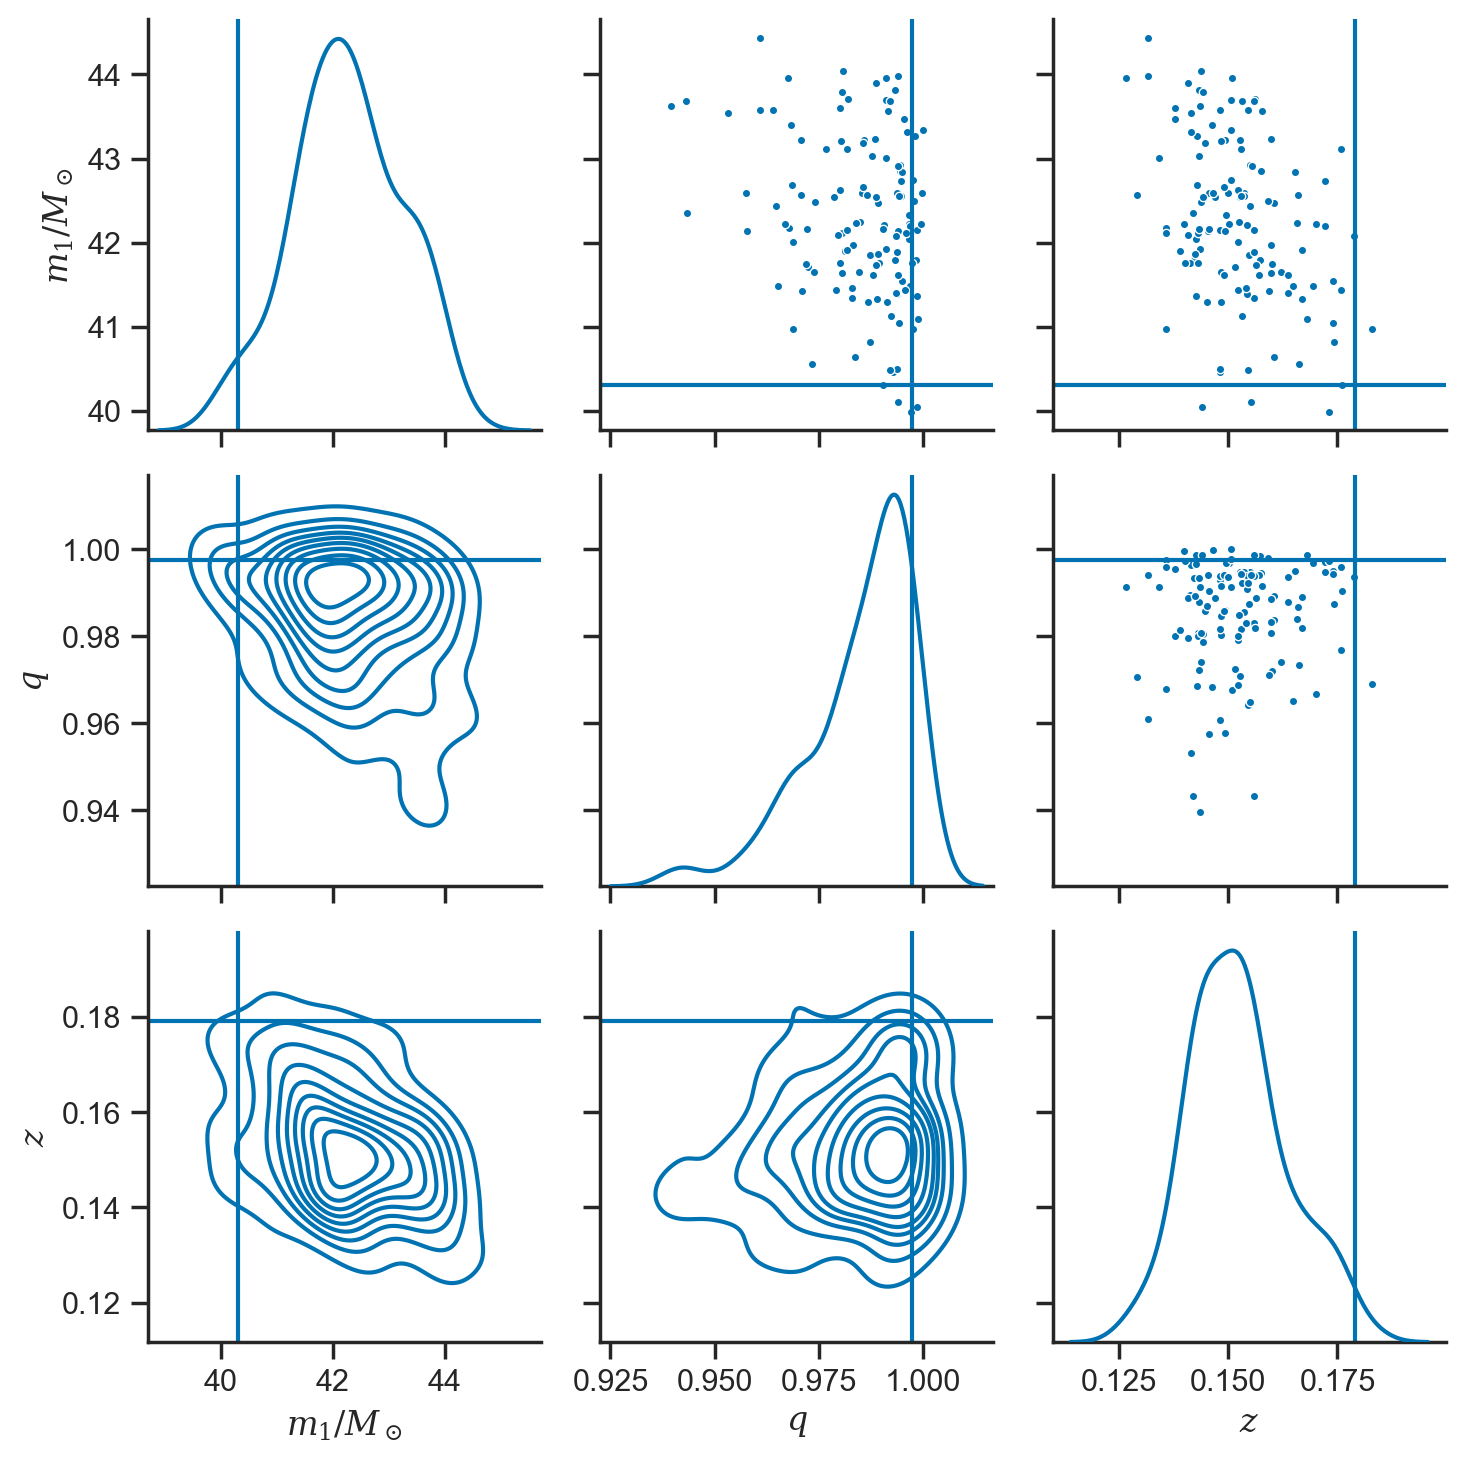

In [13]:
i = np.random.randint(len(samples['evt'].unique()))

truth_row=obs.iloc[i]
t = [truth_row['m1'], truth_row['q'], truth_row['z']]

s = samples[samples['evt'] == i]

pg = sns.PairGrid(pd.DataFrame({r'$m_1 / M_\odot$': s['m1'], r'$q$': s['q'], r'$z$': s['z']}), diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')
pg.map_lower(sns.kdeplot)

for i, tr in enumerate(t):
    for j, tc in enumerate(t):
        if i == j:
            pg.axes[i,j].axvline(tr)
        else:
            pg.axes[i,j].axvline(tc)
            pg.axes[i,j].axhline(tr)

In [14]:
g = samples.groupby('evt')
m = np.stack([s.to_numpy() for _, s in g['m1']], axis=0)
q = np.stack([s.to_numpy() for _, s in g['q']], axis=0)
z = np.stack([s.to_numpy() for _, s in g['z']], axis=0)
wt = np.stack([s.to_numpy() for _, s in g['wt']], axis=0)

In [34]:
m_true = np.array([obs['m1'].iloc[i] for i, _ in samples.groupby('evt')])
q_true = np.array([obs['q'].iloc[i] for i, _ in samples.groupby('evt')])
z_true = np.array([obs['z'].iloc[i] for i, _ in samples.groupby('evt')])

In [36]:
model = intensity_models.make_pop_model(m_true.reshape((-1, 1)), q_true.reshape((-1,1)), z_true.reshape((-1,1)), wt, obs['m1'], obs['q'], obs['z'], obs['pdraw_mqz'], len(inj))

In [37]:
chains = 4
draws = 100

with tqdm(total=2*chains*draws, smoothing=10/(2*chains*draws)) as bar:
    with model:
        trace = pm.sample(draws=draws, tune=draws, chains=chains, 
                          initvals={k: weighting.default_parameters.__getattribute__(k) for k in ['a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'beta', 'lam', 'kappa', 'zp']},
                          progressbar=False, callback=lambda trace, draw: bar.update(1))

  0%|          | 0/800 [00:00<?, ?it/s]

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, mpisn, dmbhmax, sigma, beta, log_fpl, lam, dkappa, zp, R_unit]
Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 186 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff_sel'}>,
        <Axes: title={'center': 'neff_sel'}>]], dtype=object)

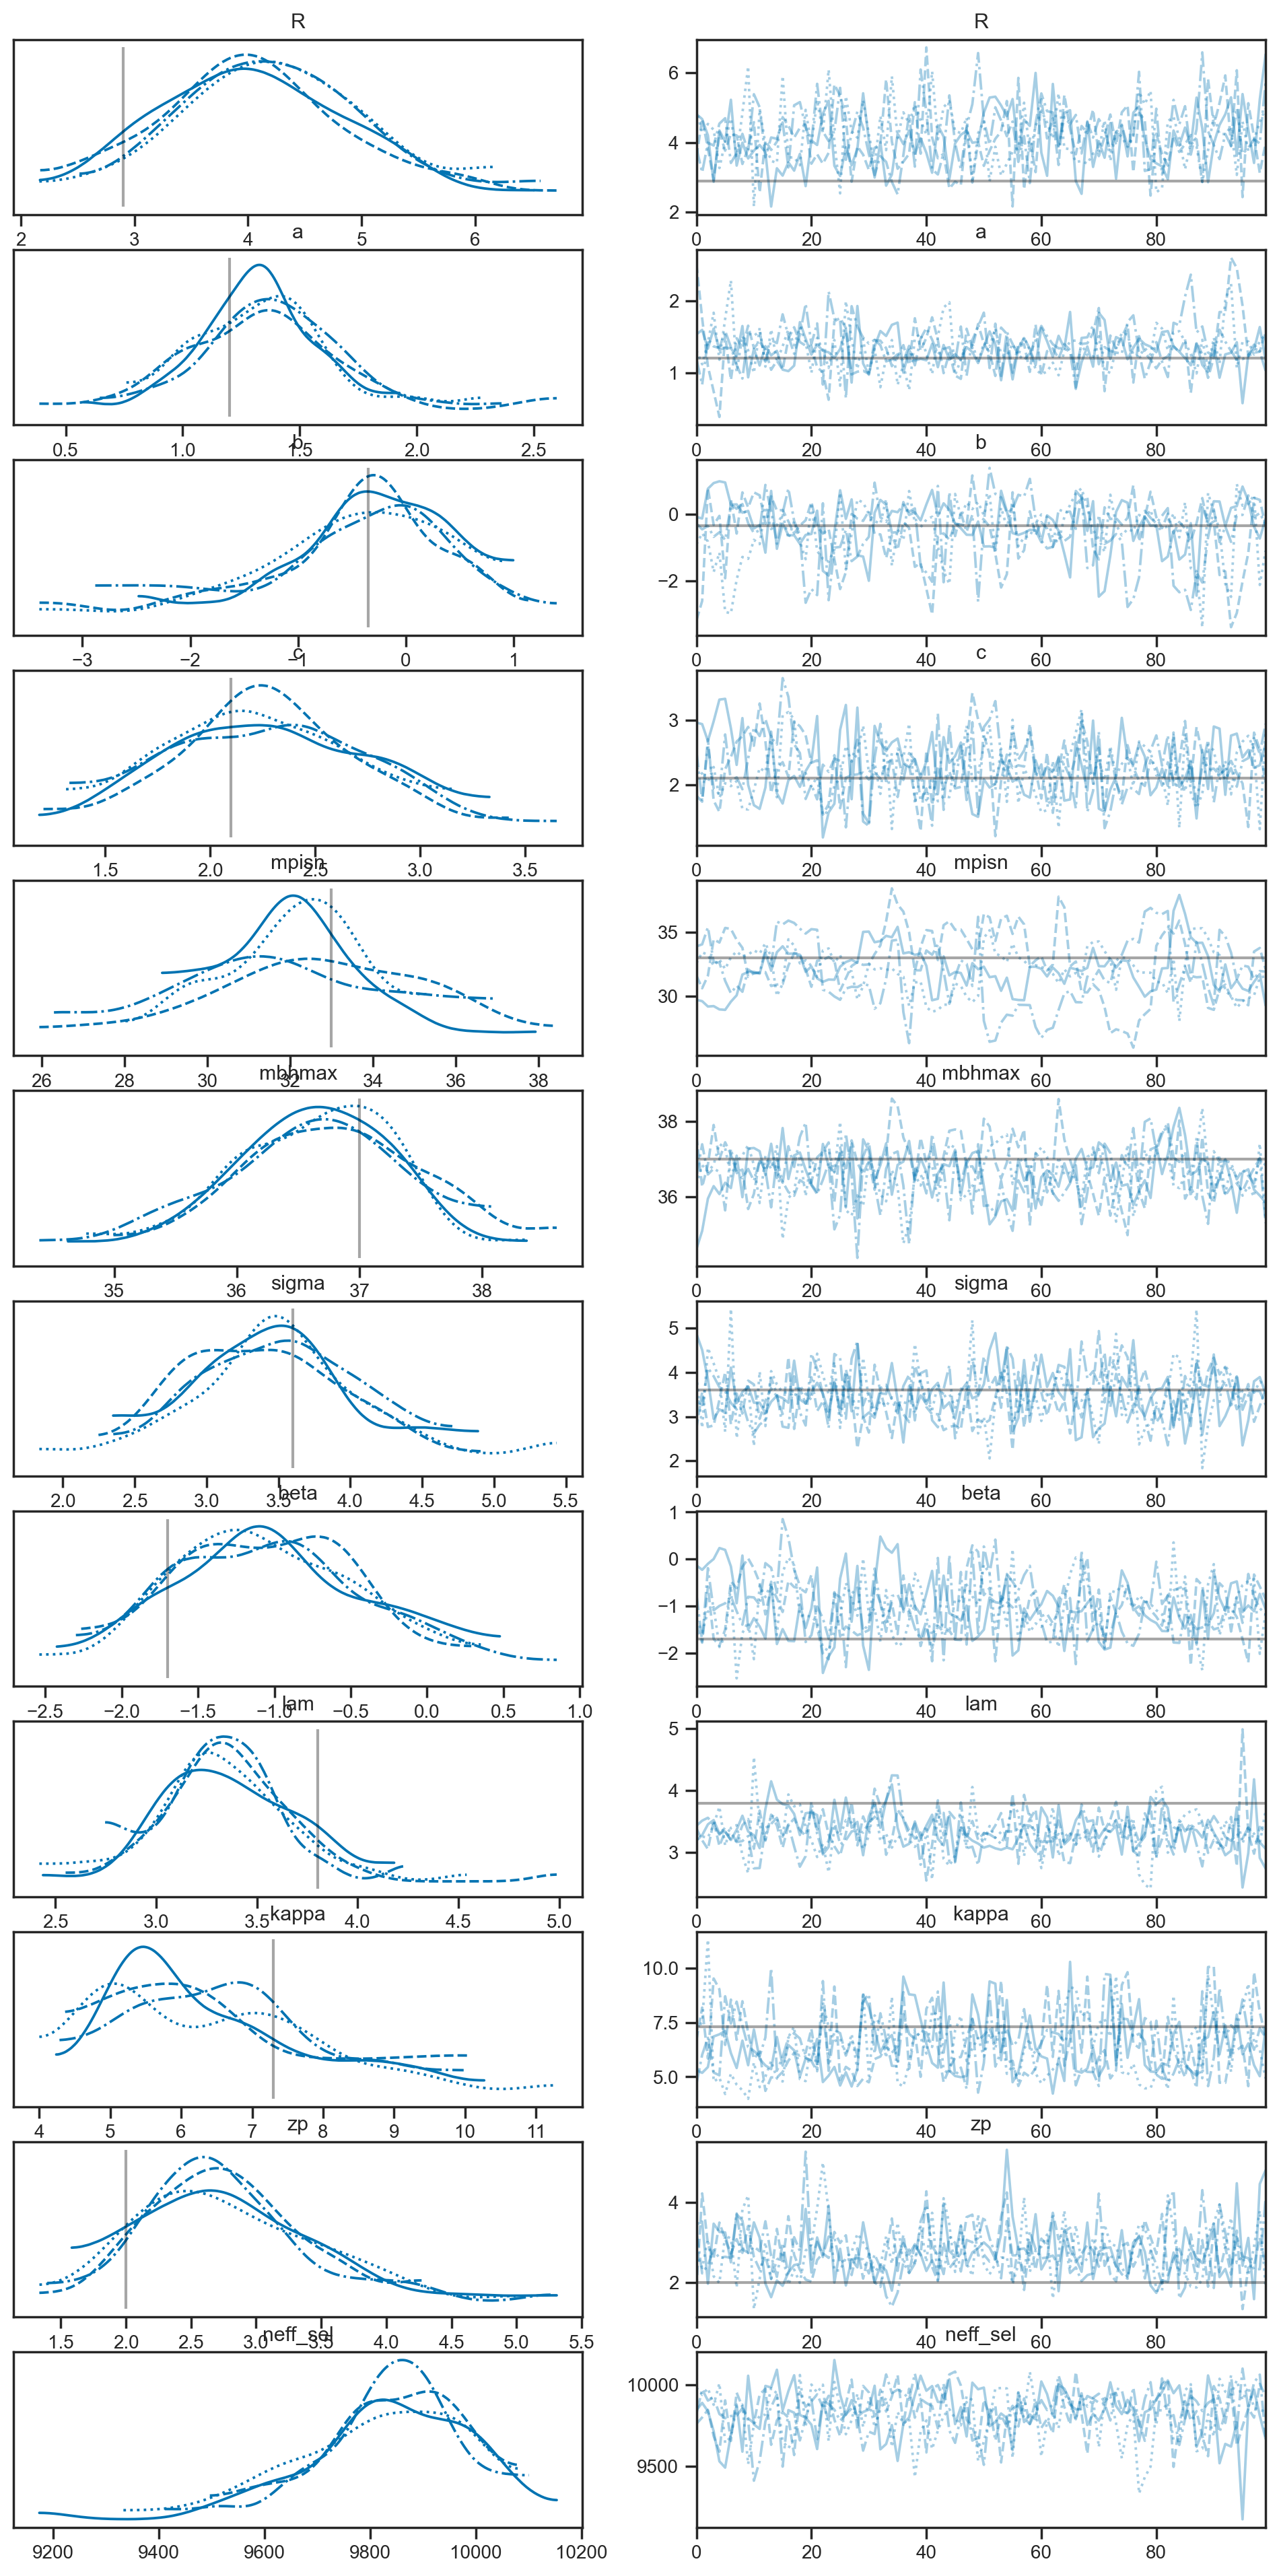

In [38]:
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'beta', 'lam', 'kappa', 'zp', 'neff_sel'],
              lines=[(k, {}, weighting.default_parameters.__getattribute__(k)) for k in ['R', 'a', 'b', 'c', 'mpisn', 'mbhmax', 'sigma', 'beta', 'lam', 'kappa', 'zp']])